<a href="https://colab.research.google.com/github/ShravaniKharade2110/CodeClause-Internship/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#import libraries
from __future__ import division

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import xgboost as xgb

In [7]:
df = pd.read_csv("/content/customer_segmentation.csv" ,  encoding='cp1252')

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175445 entries, 0 to 175444
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    175445 non-null  object 
 1   StockCode    175445 non-null  object 
 2   Description  174707 non-null  object 
 3   Quantity     175445 non-null  int64  
 4   InvoiceDate  175445 non-null  object 
 5   UnitPrice    175445 non-null  float64
 6   CustomerID   123156 non-null  float64
 7   Country      175444 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 10.7+ MB


In [10]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,175445.000000,175445.000000,123156.000000
mean,9.169415,5.107800,15286.333715
std,256.389246,100.467326,1728.637427
min,-74215.000000,0.000000,12346.000000
25%,1.000000,1.250000,13842.000000
50%,3.000000,2.250000,15179.000000
75%,10.000000,4.210000,16833.000000
max,74215.000000,16888.020000,18283.000000


In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [12]:
df['InvoiceYearMonth'] = df['InvoiceDate'].map(lambda date: 100*date.year + date.month)

In [13]:
df['Country'].value_counts()

Country
United Kingdom          162079
Germany                   2887
France                    2386
EIRE                      1994
Spain                      901
Netherlands                705
Belgium                    564
Portugal                   490
Switzerland                455
Australia                  383
Cyprus                     306
Finland                    299
Italy                      276
Channel Islands            250
Japan                      233
Norway                     212
Sweden                     146
Singapore                  118
Poland                      98
Hong Kong                   91
Greece                      85
Iceland                     84
Austria                     74
Denmark                     59
Lebanon                     45
Israel                      38
Lithuania                   35
Brazil                      32
United Arab Emirates        30
USA                         22
Czech Republic              17
Unspecified                 16


In [14]:
tx_uk = df.query("Country=='United Kingdom'").reset_index(drop=True)

In [18]:
tx_user = pd.DataFrame(df['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [19]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


In [20]:
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-03-01 14:53:00
2,12748.0,2011-05-01 13:26:00
3,12820.0,2011-01-17 12:34:00
4,12823.0,2011-03-30 10:36:00


In [21]:
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,107
1,12747.0,2011-03-01 14:53:00,64
2,12748.0,2011-05-01 13:26:00,3
3,12820.0,2011-01-17 12:34:00,108
4,12823.0,2011-03-30 10:36:00,36


In [22]:
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,17850.0,83
1,13047.0,0
2,13748.0,13
3,15100.0,111
4,15291.0,29


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

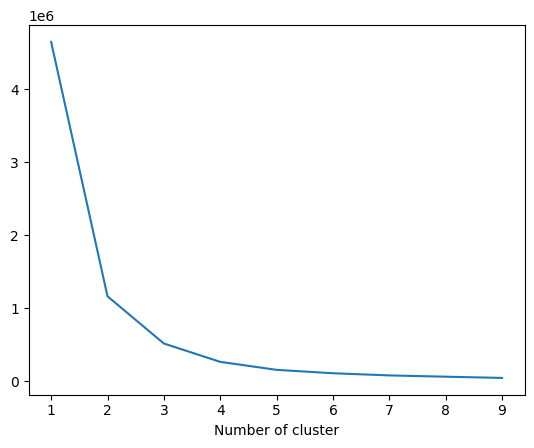

In [23]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [24]:
kmeans = KMeans(n_clusters=4)
tx_user['RecencyCluster'] = kmeans.fit_predict(tx_user[['Recency']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [25]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,83,2
1,13047.0,0,3
2,13748.0,13,3
3,15100.0,111,2
4,15291.0,29,3


In [26]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,697.0,49.527977,11.354762,33.0,39.0,48.0,58.00,71.0
1,294.0,144.850340,7.430087,120.0,140.0,146.0,150.75,155.0
2,423.0,93.801418,13.427471,72.0,82.0,93.0,104.00,119.0
3,871.0,15.471871,9.647766,0.0,7.0,16.0,23.00,32.0


In [27]:
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [28]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,83,1
1,15100.0,111,1
2,17924.0,79,1
3,14045.0,119,1
4,18085.0,111,1


In [29]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,294.0,144.850340,7.430087,120.0,140.0,146.0,150.75,155.0
1,423.0,93.801418,13.427471,72.0,82.0,93.0,104.00,119.0
2,697.0,49.527977,11.354762,33.0,39.0,48.0,58.00,71.0
3,871.0,15.471871,9.647766,0.0,7.0,16.0,23.00,32.0


In [30]:
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

In [31]:
tx_frequency.head()

,CustomerID,Frequency
0,12346.0,2
1,12747.0,32
2,12748.0,1110
3,12820.0,11
4,12823.0,3


In [32]:
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,83,1,312
1,15100.0,111,1,6
2,17924.0,79,1,7
3,14045.0,119,1,5
4,18085.0,111,1,29


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-33-e2bfb8ed226b>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-33-e2bfb8ed226b>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

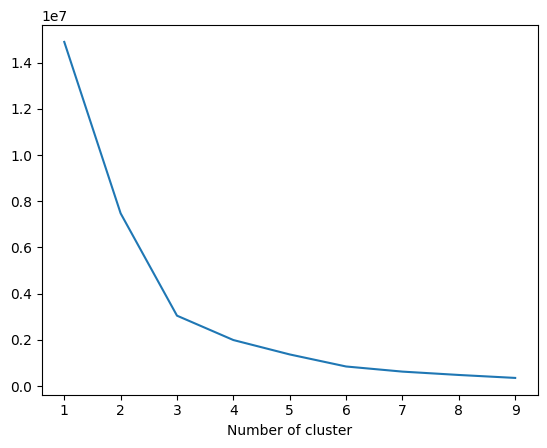

In [33]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [34]:
kmeans=KMeans(n_clusters=4)
tx_user['FrequencyCluster']=kmeans.fit_predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency', tx_user, True )
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1594.0,18.749059,12.435385,1.0,8.0,17.0,28.0,47.0
1,531.0,76.593220,23.977196,48.0,57.0,69.0,92.0,140.0
2,151.0,204.728477,65.911449,141.0,156.0,184.0,231.5,454.0
3,9.0,954.333333,315.176934,618.0,756.0,795.0,1110.0,1555.0


In [35]:
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [36]:
tx_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,1320.09
2,12748.0,7100.50
3,12820.0,170.46
4,12823.0,994.50


In [37]:
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,83,1,312,2,5288.63
1,16725.0,83,1,152,2,775.07
2,15808.0,87,1,210,2,3724.77
3,13174.0,97,1,242,2,2108.27
4,15464.0,119,1,157,2,1048.85


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-38-3ebb744cc7b2>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

<ipython-input-38-3ebb744cc7b2>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

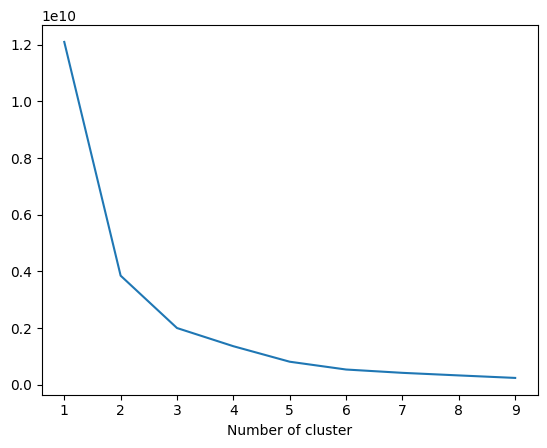

In [38]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [39]:
kmeans = KMeans(n_clusters=4)
tx_user['RevenueCluster'] = kmeans.fit_predict(tx_user[['Revenue']])

#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,2058.0,478.548863,391.732032,-1192.20,190.0475,344.350,667.1700,1716.84
1,197.0,2967.892949,1152.779627,1737.45,2050.0800,2576.520,3603.9900,6656.85
2,20.0,10688.567000,3466.399600,7100.50,8349.6225,9589.960,11600.3075,18496.78
3,10.0,28490.996000,7882.937352,21535.90,23704.7025,25666.275,31342.6150,46318.16


In [42]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value'
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [43]:
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,83,1,312,2,5288.63,1,4,Mid-Value
1,15808.0,87,1,210,2,3724.77,1,4,Mid-Value
2,13174.0,97,1,242,2,2108.27,1,4,Mid-Value
3,14688.0,31,3,151,2,2222.08,1,6,High-Value
4,14527.0,8,3,359,2,2576.52,1,6,High-Value
...,...,...,...,...,...,...,...,...,...
2280,17381.0,13,3,62,1,11548.81,2,6,High-Value
2281,16684.0,22,3,99,1,18496.78,2,6,High-Value
2282,12748.0,3,3,1110,3,7100.50,2,8,High-Value
2283,17841.0,2,3,1555,3,8868.04,2,8,High-Value


In [44]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [45]:
tx_uk['InvoiceDate'].describe()

count                           162079
mean     2011-02-11 00:43:59.291826688
min                2010-12-01 08:26:00
25%                2011-01-04 13:22:00
50%                2011-02-11 10:40:00
75%                2011-03-24 12:11:00
max                2011-05-05 12:37:00
Name: InvoiceDate, dtype: object